In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, GaussianNoise, Lambda, multiply
import tensorflow.keras.backend as K
import tensorflow as tf
from functools import partial

Welcome to JupyROOT 6.10/08


In [2]:
n_particles = 10000/2
p = np.random.uniform(0.3,10.,n_particles)
mp = np.random.uniform(1/10.,1/0.3,n_particles)
p_mp = 1./mp 

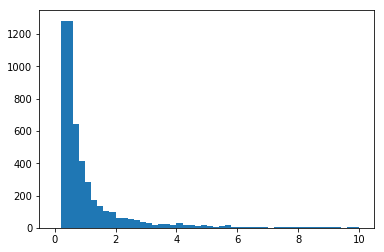

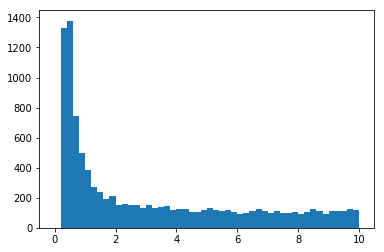

In [3]:
plt.hist(p_mp,50,range=(0.,10.))
plt.show()
p_ges = np.concatenate([p,p_mp])
plt.hist(p_ges,50,range=(0,10))
plt.show()

In [4]:
mass_pi = 0.139
mass_mu = 0.105
mass_e = 0.000511
mass_p = 0.938
mass_K = 0.494
masses = [mass_pi, mass_mu, mass_e, mass_p, mass_K]
masses

[0.139, 0.105, 0.000511, 0.938, 0.494]

In [5]:
signals = []
for mass in masses:
    ITS_tmp = []
    TPCROC0_tmp = []
    TPCROC1_tmp = []
    TPCROC2_tmp = []
    TRD_tmp = []
    TOF_tmp = []
    for p in p_ges:
        bg = p/mass
        beta = bg/math.sqrt(1.+ bg*bg);
        BBS = ROOT.AliExternalTrackParam.BetheBlochSolid(bg)
        BBA = ROOT.AliExternalTrackParam.BetheBlochAleph(bg)
        ITS_tmp.append(np.random.normal(BBS,0.1*BBS) ) ## ITS dEdx = smeared gaus 10% 
        TPCROC0_tmp.append(np.random.normal(BBA,0.1*BBA) )## TPC dEdx = smeared gaus 10% for 1st layer
        TPCROC1_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 2nd layer
        TPCROC2_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TPC dEdx = smeared gaus 10% for 3d layer
        TRD_tmp.append(np.random.normal(BBA,0.1*BBA) )  ## TRD dEdx = smeared gaus 10% 
        TOF_tmp.append(np.random.normal(beta,0.1*beta) )  ## TOF - smeared with .... gaussian
    signals.append({'ITS': ITS_tmp, 'TPCROC0': TPCROC0_tmp, 'TPCROC1': TPCROC1_tmp, 'TPCROC1': TPCROC1_tmp, 
                    'TPCROC2': TPCROC2_tmp, 'TRD': TRD_tmp, 'TOF': TOF_tmp})

[]

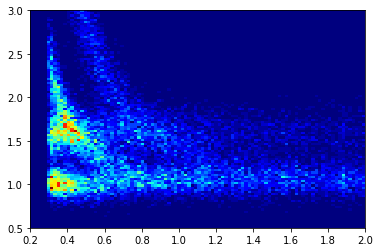

In [6]:
df_list=[]
for i, val in enumerate(masses):
    df = pd.DataFrame.from_dict(signals[i])
    df['p'] = pd.Series(p_ges, index=df.index)
    df['particle'] = pd.Series(i, index=df.index)
    df_list.append(df)
df_all = pd.concat([df_list[0],df_list[2],df_list[3],df_list[4]], ignore_index=True)
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.plot()

In [7]:
N=len(df_all)
probabilty = 0.95

flips_raw = (1*(np.random.random(size=6*N)<probabilty)).reshape(6,-1)

flips=flips_raw[0]
for i in range(1,6):
    # (1<<i = 2**i)
    flips=flips_raw[i]*(1<<i) + flips


df_all.loc[:,'flips']=flips
df_all.head(5)

,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips
0,0.002263,0.884046,1.372702,1.268054,1.339133,1.224131,4.436232,0,47
1,0.001891,1.109201,1.295813,1.536246,1.130210,1.200917,8.009063,0,31
2,0.001981,0.976484,1.235396,1.300277,1.634170,1.398917,9.455330,0,59
3,0.001999,0.975399,1.144921,1.443357,1.213328,1.291755,6.624797,0,62
4,0.001576,0.974154,1.230762,1.130028,1.059009,1.005102,0.354316,0,63


In [8]:
# prepare "flips-Data" and weights
for i ,name in enumerate(['ITS','TOF','TPCROC0','TPCROC1','TPCROC2','TRD']):
    # calculate "flip= 0/1"
    f=(np.array(df_all['flips'])>>i)&1
    # if f=0 substitute value by mean
    m=df_all[name].mean()
    df_all.loc[:,name+'_mr']= df_all[name].multiply(f,axis='index')+m*(1-f) #mean replaced
    df_all.loc[:,name+'_w']=1.0*f #weight
    df_all.loc[:,name+'_0']= df_all[name].multiply(f,axis='index') #zeros
    
# generate data for stage 2
df_stage_2=df_all.copy()
df_stage_3=df_all.copy()
df_all[df_all['particle']==0].head(10)

,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips,ITS_mr,...,TPCROC0_0,TPCROC1_mr,TPCROC1_w,TPCROC1_0,TPCROC2_mr,TPCROC2_w,TPCROC2_0,TRD_mr,TRD_w,TRD_0
0,0.002263,0.884046,1.372702,1.268054,1.339133,1.224131,4.436232,0,47,0.002263,...,1.372702,1.268054,1.0,1.268054,1.478230,0.0,0.000000,1.224131,1.0,1.224131
1,0.001891,1.109201,1.295813,1.536246,1.130210,1.200917,8.009063,0,31,0.001891,...,1.295813,1.536246,1.0,1.536246,1.130210,1.0,1.130210,1.479566,0.0,0.000000
2,0.001981,0.976484,1.235396,1.300277,1.634170,1.398917,9.455330,0,59,0.001981,...,0.000000,1.300277,1.0,1.300277,1.634170,1.0,1.634170,1.398917,1.0,1.398917
3,0.001999,0.975399,1.144921,1.443357,1.213328,1.291755,6.624797,0,62,0.002521,...,1.144921,1.443357,1.0,1.443357,1.213328,1.0,1.213328,1.291755,1.0,1.291755
4,0.001576,0.974154,1.230762,1.130028,1.059009,1.005102,0.354316,0,63,0.001576,...,1.230762,1.130028,1.0,1.130028,1.059009,1.0,1.059009,1.005102,1.0,1.005102
5,0.002082,0.984501,1.438866,1.404455,1.363916,1.202953,9.994997,0,47,0.002082,...,1.438866,1.404455,1.0,1.404455,1.478230,0.0,0.000000,1.202953,1.0,1.202953
6,0.002062,0.961566,1.347216,1.444773,1.303658,1.129715,3.155153,0,63,0.002062,...,1.347216,1.444773,1.0,1.444773,1.303658,1.0,1.303658,1.129715,1.0,1.129715
7,0.001876,1.000321,1.652878,1.274850,1.149914,1.361164,7.927750,0,47,0.001876,...,1.652878,1.274850,1.0,1.274850,1.478230,0.0,0.000000,1.361164,1.0,1.361164
8,0.001777,1.080818,1.290951,1.336653,1.137218,1.215426,2.593912,0,63,0.001777,...,1.290951,1.336653,1.0,1.336653,1.137218,1.0,1.137218,1.215426,1.0,1.215426
9,0.002102,0.932273,1.275207,1.130175,1.361885,1.411688,6.161774,0,63,0.002102,...,1.275207,1.130175,1.0,1.130175,1.361885,1.0,1.361885,1.411688,1.0,1.411688


In [9]:
train, test =train_test_split(df_all, test_size=0.5)

# Create autoencoders

In [16]:
def custom_loss(y_true, y_pred,weights):
    return K.sum(K.square((y_true - y_pred)*weights),axis=1)

def sample_z(args):
    mean,ln_var = args
    eps        = K.random_normal(shape=(2,),mean=0., stddev=1.0)
    return     mean+K.exp(ln_var/2)*eps


inputs = Input(shape=(6,))
inputw = Input(shape=(6,))
#noise = GaussianNoise(0.2)(inputs)
enc1   = Dense(units=64, activation='selu')(inputs)
enc2   = Dense(units=64, activation='selu')(enc1)
enc3   = Dense(units=64, activation='selu')(enc2)
enc4   = Dense(units=64, activation='selu')(enc3)

mean   = Dense(units=2 , activation='linear')(enc4)
ln_var = Dense(units=2 , activation='linear')(enc4)

z      = Lambda(sample_z)([mean,ln_var])
dec1   = Dense(units=64, activation='selu')(z)
dec2   = Dense(units=64, activation='selu')(dec1)
dec3   = Dense(units=64, activation='selu')(dec2)
dec4   = Dense(units=64, activation='selu')(dec3)
outputs= Dense(units=6, activation='linear')(dec4)

c_loss = partial(custom_loss, weights=inputw)
        
modelpt = Model(inputs=inputs,outputs=outputs)
models2 = Model(inputs=inputs,outputs=outputs)
modell = Model(inputs=inputs,outputs=outputs)
model0 = Model(inputs=inputs,outputs=outputs)
model1 = Model(inputs=[inputs,inputw],outputs=outputs)


def vae_loss(y_true,y_pred):
    scaler=10
    l1 = K.sum(K.square((y_true - y_pred)),axis=1)*scaler
    l2 = 0.5*K.sum(K.exp(ln_var)+K.square(mean)-1. - ln_var,axis=1)
    return l1+l2

def weighted_vae_loss(y_true,y_pred,weights):
    scaler=10
    l1 = K.sum(K.square((y_true - y_pred)*weights),axis=1)*scaler
    l2 = 0.5*K.sum(K.exp(ln_var)+K.square(mean)-1. - ln_var,axis=1)
    return l1+l2

w_loss = partial(weighted_vae_loss,weights=inputw)

modelpt.compile(loss=vae_loss,
              optimizer='adam',
              metrics=['mse'])
models2.compile(loss=vae_loss,
              optimizer='adam',
              metrics=['mse'])
modell.compile(loss=vae_loss,
              optimizer='adam',
              metrics=['mse'])
model0.compile(loss=vae_loss,
              optimizer='adam',
              metrics=['mse'])
model1.compile(loss=w_loss,
              optimizer='adam',
              metrics=['mse'])

In [17]:
model0.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 6)            0                                            
__________________________________________________________________________________________________
dense_51 (Dense)                (None, 64)           448         input_13[0][0]                   
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 64)           4160        dense_51[0][0]                   
__________________________________________________________________________________________________
dense_53 (Dense)                (None, 64)           4160        dense_52[0][0]                   
__________________________________________________________________________________________________
dense_54 (

# perfect tracks

In [18]:
train_pt = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_pt = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
scaler_pt = StandardScaler()
scaler_pt.fit( train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]])

StandardScaler(copy=True, with_mean=True, with_std=True)

In [19]:
modelpt.fit(scaler_pt.transform(train_pt), scaler_pt.transform(train_pt), epochs=5, batch_size=32, 
          validation_data=[scaler_pt.transform(test_pt),scaler_pt.transform(test_pt)])

Train on 20000 samples, validate on 20000 samples
Epoch 1/5
20000/20000 [==============================] - 8s 418us/step - loss: 21.2399 - mean_squared_error: 0.0868 - val_loss: 13.6261 - val_mean_squared_error: 0.0502
Epoch 2/5
20000/20000 [==============================] - 6s 282us/step - loss: 13.4267 - mean_squared_error: 0.0482 - val_loss: 13.1318 - val_mean_squared_error: 0.0465
Epoch 3/5
20000/20000 [==============================] - 6s 285us/step - loss: 12.6807 - mean_squared_error: 0.0447 - val_loss: 11.6674 - val_mean_squared_error: 0.0401
Epoch 4/5
20000/20000 [==============================] - 6s 285us/step - loss: 12.5666 - mean_squared_error: 0.0439 - val_loss: 12.2463 - val_mean_squared_error: 0.0431
Epoch 5/5
20000/20000 [==============================] - 6s 280us/step - loss: 12.4001 - mean_squared_error: 0.0432 - val_loss: 12.0539 - val_mean_squared_error: 0.0424


2019-01-29 16:39:07.082330: I tensorflow/core/platform/cpu_feature_guard.cc:141] Your CPU supports instructions that this TensorFlow binary was not compiled to use: FMA


In [20]:
out = scaler_pt.inverse_transform(modelpt.predict(scaler_pt.transform(test_pt)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

,index,ITS,TOF,TPCROC0,TPCROC1,TPCROC2,TRD,p,particle,flips,...,TPCROC2_0,TRD_mr,TRD_w,TRD_0,ITS_ae,TOF_ae,TPCROC0_ae,TPCROC1_ae,TPCROC2_ae,TRD_ae
0,2218,0.001747,0.904396,0.955658,1.067499,1.161082,1.061730,1.884060,0,63,...,1.161082,1.061730,1.0,1.061730,0.001780,0.896775,1.013679,1.131342,1.033402,1.043089
1,34834,0.001929,0.965696,1.096356,1.161584,1.271978,1.190690,7.127193,4,63,...,1.271978,1.190690,1.0,1.190690,0.001882,0.963929,1.127144,1.183596,1.133208,1.157786
2,21099,0.001881,1.014874,1.168290,0.929227,0.970245,1.220871,8.658419,3,63,...,0.970245,1.220871,1.0,1.220871,0.001760,1.002868,1.050533,1.115884,1.050417,1.043513


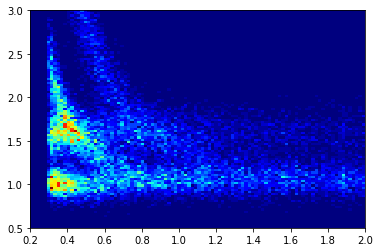

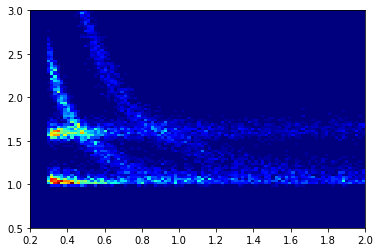

In [21]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC2_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# Train with zeros

In [ ]:
train_0 = train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]]
test_0 = test[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]]
scaler_0 = StandardScaler()
scaler_0.fit( train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]])
#scaler_0.fit( train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]) 

In [ ]:
train[["ITS_0", "TOF_0", "TPCROC0_0", "TPCROC1_0", "TPCROC2_0", "TRD_0"]].head()

In [ ]:
train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]].head()


In [ ]:
model0.fit(scaler_0.transform(train_0), scaler_0.transform(train_0), epochs=5, batch_size=32, 
          validation_data=[scaler_0.transform(test_0),scaler_0.transform(test_0)])

In [ ]:
out = scaler_0.inverse_transform(model0.predict(scaler_0.transform(test_0)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC2_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# labels for missing tracks

In [ ]:
train_in = train[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
train_out = train[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
test_in = test[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
test_out = test[["ITS", "TOF", "TPCROC0", "TPCROC1", "TPCROC2", "TRD"]]
scaler_in = StandardScaler()
scaler_out = StandardScaler()
scaler_in.fit(train_in)
scaler_out.fit(train_out)

In [ ]:
modell.fit(scaler_in.transform(train_in), scaler_out.transform(train_out), epochs=5, batch_size=32, 
          validation_data=[scaler_in.transform(test_in),scaler_out.transform(test_out)])

In [ ]:
out = scaler_out.inverse_transform(modell.predict(scaler_in.transform(test_in)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
#test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# mean input, zero weights for missing values

In [ ]:
train_mr = train[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
test_mr = test[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
train_w    = train[["ITS_w", "TOF_w", "TPCROC0_w", "TPCROC1_w", "TPCROC2_w", "TRD_w"]]
test_w     = test[["ITS_w", "TOF_w", "TPCROC0_w", "TPCROC1_w", "TPCROC2_w", "TRD_w"]]

In [ ]:
scaler_mr = StandardScaler()
scaler_mr.fit(train_mr)

In [ ]:
model1.fit([scaler_mr.transform(train_mr),train_w], scaler_mr.transform(train_mr), epochs=5, batch_size=32, 
          validation_data=[[scaler_mr.transform(test_mr),train_w],scaler_mr.transform(test_mr)])

In [ ]:
out = scaler_mr.inverse_transform(model1.predict([scaler_mr.transform(test_mr),test_w]))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
#test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()

# second iteration, replace missing values by values from first iteration

In [ ]:
# stage 2
stage2_data = df_stage_2[["ITS_mr", "TOF_mr", "TPCROC0_mr", "TPCROC1_mr", "TPCROC2_mr", "TRD_mr"]]
out = scaler_mr.inverse_transform(models2.predict(scaler_mr.transform(stage2_data)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
for i ,name in enumerate(['ITS','TOF','TPCROC0','TPCROC1','TPCROC2','TRD']):
    # calculate "flip= 0/1"
    f=(np.array(df_stage_2['flips'])>>i)&1
    m=AE_predict[name+'_ae']
    df_stage_2.loc[:,name+'_s2']= df_stage_2[name].multiply(f,axis='index')+m*(1-f)

In [ ]:
train, test =train_test_split(df_stage_2, test_size=0.5)
train_s2 = train[["ITS_s2", "TOF_s2", "TPCROC0_s2", "TPCROC1_s2", "TPCROC2_s2", "TRD_s2"]]
test_s2 = test[["ITS_s2", "TOF_s2", "TPCROC0_s2", "TPCROC1_s2", "TPCROC2_s2", "TRD_s2"]]

In [ ]:
scaler_s2 = StandardScaler()
scaler_s2.fit(train_s2)
models2.fit(scaler_s2.transform(train_s2), scaler_s2.transform(train_s2), epochs=5, batch_size=32, 
          validation_data=[scaler_s2.transform(test_s2),scaler_s2.transform(test_s2)])

In [ ]:
out = scaler_s2.inverse_transform(models2.predict(scaler_s2.transform(test_s2)))
AE_predict = pd.DataFrame(out)
AE_predict.columns = ["ITS_ae", "TOF_ae", "TPCROC0_ae", "TPCROC1_ae", "TPCROC2_ae", "TRD_ae"]
test = test.reset_index()
df_test = pd.concat([test,AE_predict], axis = 1)
df_test.head(3)

In [ ]:
plt.hist2d(df_all["p"], df_all["TPCROC1"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()
plt.hist2d(df_test["p"], df_test["TPCROC1_ae"], bins=(100, 100), cmap=plt.cm.jet, range = [[0.2, 2], [0.5, 3]])
plt.show()